# W10 - Class Assignment  
**Howie Homan / 0706022310040**


# Import Library



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

In [3]:
# Load the customer dataset
import pandas as pd

url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/customer_classification_data.csv"
df = pd.read_csv(url)

# Display the first few records to confirm successful loading
df.head()

,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168


## Data Inspection and Cleaning

This section provides an overview and ensures the **Customer Dataset** is clean and ready for clustering analysis.  
1. **Initial Inspection:** Displays dataset dimensions, feature information, and summary statistics to understand customer attributes and data types.  
2. **Missing Values and Duplicates:** Detects any incomplete or duplicate customer records that might affect clustering accuracy.  
3. **Unique Values Exploration:** Reviews unique entries—especially for the **Education** feature—to confirm categorical consistency before encoding.  
4. **Handling Missing Values:**  
   - **Numerical columns** are imputed using the **median** to minimize the influence of extreme values.  
   - **Categorical columns** (like *Education*) are imputed using the **mode** (most frequent category) to maintain representativeness.  

After handling missing values, the dataset is confirmed to be **complete and consistent**, ready for **encoding and exploratory data analysis**.


In [4]:
# ===============================
# 1. Initial Data Inspection
# ===============================
print("\n=== Dataset Overview ===")
print(f"Dimensions of dataset: {df.shape}")

print("\n--- Dataset Information ---")
df.info()

print("\n--- Descriptive Statistics ---")
display(df.describe().T)


# ===============================
# 2. Check Missing Values and Duplicates
# ===============================
print("\n=== Data Quality Check ===")
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")


# ===============================
# 3. Explore Unique Values
# ===============================
print("\n=== Unique Value Exploration ===")
for column in df.columns:
    unique_count = df[column].nunique()
    print(f"\n{column} ({unique_count} unique values):")
    print(df[column].value_counts().head(5))


# ===============================
# 4. Handle Missing Values (Imputation)
# ===============================
df_clean = df.copy()

for column in df_clean.columns:
    if df_clean[column].dtype == "object":
        # For categorical features (e.g., Education), fill missing values with the mode
        df_clean[column].fillna(df_clean[column].mode()[0], inplace=True)
    else:
        # For numerical features, fill missing values with the median
        df_clean[column].fillna(df_clean[column].median(), inplace=True)

print("\n=== After Imputation ===")
print("Total remaining missing values:", df_clean.isnull().sum().sum())
print("Data cleaning process completed successfully.")



=== Dataset Overview ===
Dimensions of dataset: (500, 12)

--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Income                 500 non-null    float64
 1   Age                    500 non-null    int64  
 2   Education              500 non-null    object 
 3   Credit_Score           500 non-null    int64  
 4   Years_with_Bank        500 non-null    int64  
 5   Transaction_Count      500 non-null    int64  
 6   Balance                500 non-null    float64
 7   Loan_Approval_Amount   500 non-null    float64
 8   Credit_Card_Limit      500 non-null    float64
 9   Purchase_Frequency     500 non-null    float64
 10  Customer_Satisfaction  500 non-null    int64  
 11  Online_Activity        500 non-null    float64
dtypes: float64(6), int64(5), object(1)
memory usage: 47.0+ KB

--- Descriptive

,count,mean,std,min,25%,50%,75%,max
Income,500.0,62244.823110,21881.731581,25352.160710,43586.942127,61513.145375,79805.933200,99913.525490
Age,500.0,40.010000,13.051229,18.000000,29.000000,39.000000,51.000000,64.000000
Credit_Score,500.0,564.992000,159.206663,300.000000,426.000000,562.000000,692.000000,849.000000
Years_with_Bank,500.0,10.806000,5.151061,1.000000,7.000000,11.000000,15.000000,19.000000
Transaction_Count,500.0,48.486000,28.742339,1.000000,25.000000,48.000000,72.000000,99.000000
Balance,500.0,5062.825191,2926.414765,44.900440,2563.861164,4962.940262,7575.192218,9984.440444
Loan_Approval_Amount,500.0,25395.518396,14257.083307,1087.318821,13254.375542,25523.286385,38359.706343,49971.895230
Credit_Card_Limit,500.0,10609.972452,5572.250431,1017.345471,5788.708258,10716.457885,15530.730127,19968.520560
Purchase_Frequency,500.0,0.512753,0.282915,0.000813,0.272196,0.531370,0.763411,0.993942
Customer_Satisfaction,500.0,2.564000,1.101058,1.000000,2.000000,3.000000,4.000000,4.000000



=== Data Quality Check ===
Missing values per column:
 Income                   0
Age                      0
Education                0
Credit_Score             0
Years_with_Bank          0
Transaction_Count        0
Balance                  0
Loan_Approval_Amount     0
Credit_Card_Limit        0
Purchase_Frequency       0
Customer_Satisfaction    0
Online_Activity          0
dtype: int64

Number of duplicate rows: 0

=== Unique Value Exploration ===

Income (500 unique values):
Income
62939.97879    1
66161.01279    1
78639.20248    1
70207.25321    1
56311.47811    1
Name: count, dtype: int64

Age (47 unique values):
Age
29    17
47    17
56    17
34    17
33    16
Name: count, dtype: int64

Education (4 unique values):
Education
High School    143
Bachelor       129
PhD            117
Master         111
Name: count, dtype: int64

Credit_Score (328 unique values):
Credit_Score
567    6
410    5
455    4
519    4
677    3
Name: count, dtype: int64

Years_with_Bank (19 unique values):

/tmp/ipython-input-583086920.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[column].fillna(df_clean[column].median(), inplace=True)
/tmp/ipython-input-583086920.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

## Exploratory Data Analysis (EDA)

This section visually explores the **Customer Dataset** to uncover patterns and relationships between key customer attributes that may influence segmentation.

### 1. Scatter Plot: Income vs. Credit Score
A scatter plot is used to examine the relationship between **Income** and **Credit Score**.  
- Customers with higher incomes generally have higher credit scores, indicating more stable financial behavior.  
- A few low-credit-score customers with high income may reflect inconsistent repayment habits or new banking relationships.

### 2. Correlation Heatmap
The heatmap displays pairwise correlations among all numerical features.  
- Strong positive relationships are observed between **Balance**, **Credit_Card_Limit**, and **Income**, showing that financially stronger customers maintain higher account balances and credit access.  
- **Customer_Satisfaction** and **Online_Activity** correlations help highlight engagement-driven customer groups.  

These insights provide a foundation for meaningful **cluster formation** and further customer segmentation analysis.


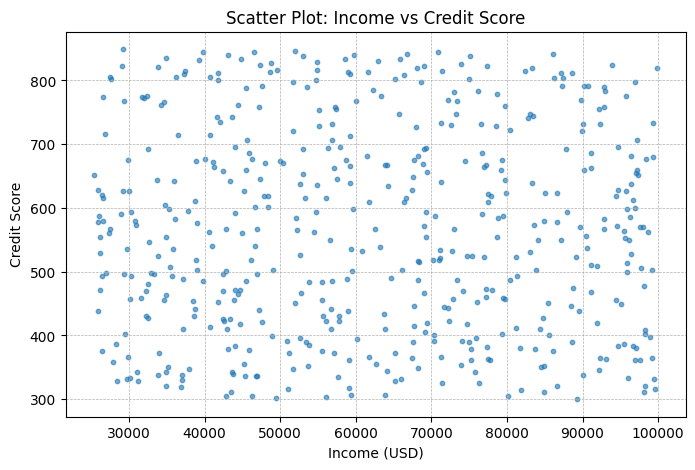


Insight 1: The scatter plot shows no clear linear relationship between income and credit score. Customers across all income levels display a wide range of credit scores, suggesting that creditworthiness is influenced by other factors such as repayment behavior or account history rather than income alone.


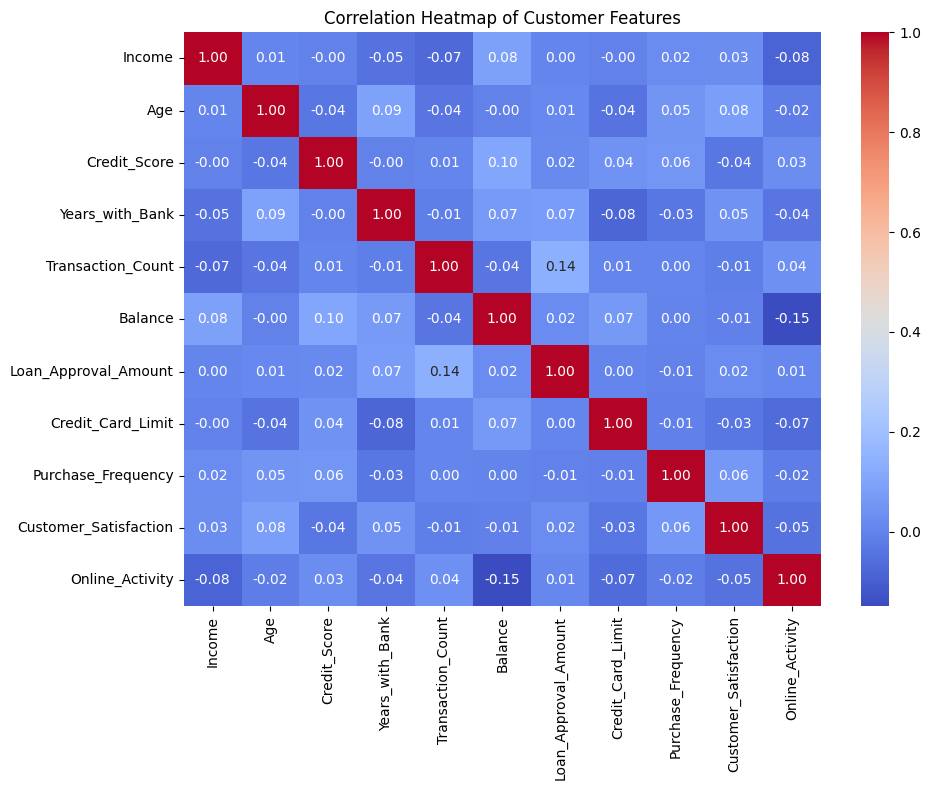


Insight 2: The correlation heatmap shows generally weak relationships among most features, indicating that each attribute provides unique information for clustering. Slight positive correlations appear between 'Transaction_Count' and 'Loan_Approval_Amount', implying that more active customers may have better loan histories. A minor negative link between 'Balance' and 'Purchase_Frequency' suggests that frequent purchasers tend to maintain lower balances. Overall, the dataset’s diversity supports effective customer segmentation.


In [6]:
# ----------------------------------------------------------
# PART B: EXPLORATORY DATA ANALYSIS (EDA)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualization 1: Scatter Plot between Income and Credit Score
plt.figure(figsize=(8, 5))
plt.scatter(
    df_clean["Income"],
    df_clean["Credit_Score"],
    s=10,
    alpha=0.6
)
plt.title("Scatter Plot: Income vs Credit Score", fontsize=12)
plt.xlabel("Income (USD)")
plt.ylabel("Credit Score")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print("\nInsight 1: The scatter plot shows no clear linear relationship between income "
      "and credit score. Customers across all income levels display a wide range of "
      "credit scores, suggesting that creditworthiness is influenced by other factors "
      "such as repayment behavior or account history rather than income alone.")


# Visualization 2: Correlation Heatmap
numeric_features = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Customer Features", fontsize=12)
plt.tight_layout()
plt.show()

print("\nInsight 2: The correlation heatmap shows generally weak relationships among most features, "
      "indicating that each attribute provides unique information for clustering. "
      "Slight positive correlations appear between 'Transaction_Count' and 'Loan_Approval_Amount', "
      "implying that more active customers may have better loan histories. "
      "A minor negative link between 'Balance' and 'Purchase_Frequency' suggests that frequent purchasers "
      "tend to maintain lower balances. Overall, the dataset’s diversity supports effective customer segmentation.")


### EDA Summary and Insights

The exploratory analysis provides key observations about customer behavior and data characteristics:  

- The **Income vs. Credit Score** scatter plot shows no strong linear trend, indicating that a customer's creditworthiness is not directly determined by income level. This suggests that other factors, such as repayment habits and account history, may play a larger role in influencing credit scores.  
- The **Correlation Heatmap** reveals generally weak relationships between features, meaning that each attribute provides distinct information for clustering. This diversity is beneficial, as it allows the clustering model to identify unique customer groups based on multiple behavioral and financial dimensions.  
- Slight positive correlations between **Transaction_Count** and **Loan_Approval_Amount** suggest that more active customers may have a stronger financial track record. Meanwhile, a small negative correlation between **Balance** and **Purchase_Frequency** indicates that frequent spenders tend to maintain lower balances.  

Overall, the dataset shows **balanced feature independence** and **meaningful variation** across customer profiles—making it well-suited for hierarchical clustering in the next analysis stage.


## Part C – Data Preparation for Hierarchical Clustering

Before applying hierarchical clustering, the dataset must be encoded and scaled to ensure that all features contribute fairly to distance-based calculations.

1. **Feature Preparation**  
   The dataset consists primarily of **numerical attributes**, with one categorical feature (**Education**) that requires encoding before clustering.

2. **Encoding Categorical Variables**  
   The **Education** column, an ordinal variable representing education levels (High School → PhD), is encoded using **LabelEncoder** to convert it into numerical form while preserving its natural order.

3. **Feature Scaling**  
   Two versions of the dataset are prepared:  
   - **Unscaled Data:** retains original feature magnitudes.  
   - **Scaled Data:** standardized using **StandardScaler** so each feature has zero mean and unit variance, ensuring no single variable dominates the clustering process.

4. **Clustering Evaluation (Silhouette Score)**  
   The **silhouette score** is used to measure how well each data point fits within its cluster.  
   - Clustering is tested across a range of cluster numbers (e.g., 2–10) using different **linkage methods** such as *ward*, *complete*, and *average*.  
   - The method and number of clusters with the **highest silhouette score** are selected for further interpretation.

5. **Interpretation and Readiness**  
   The preprocessed data, available in both scaled and unscaled forms, is now ready for hierarchical clustering.  
   This preparation ensures that the results will accurately reflect **customer similarity** patterns across demographic, financial, and behavioral dimensions.


Numerical Columns: ['Income', 'Age', 'Credit_Score', 'Years_with_Bank', 'Transaction_Count', 'Balance', 'Loan_Approval_Amount', 'Credit_Card_Limit', 'Purchase_Frequency', 'Customer_Satisfaction', 'Online_Activity']
Categorical Columns: ['Education']

=== Silhouette Analysis (Scaled Data) ===


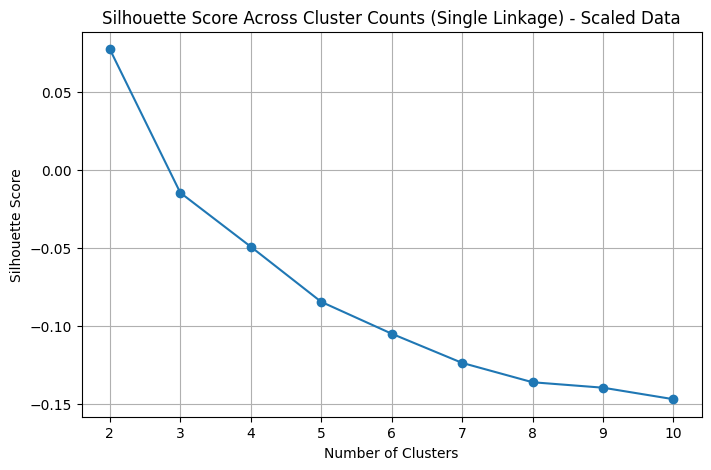


=== Silhouette Analysis (Unscaled Data) ===


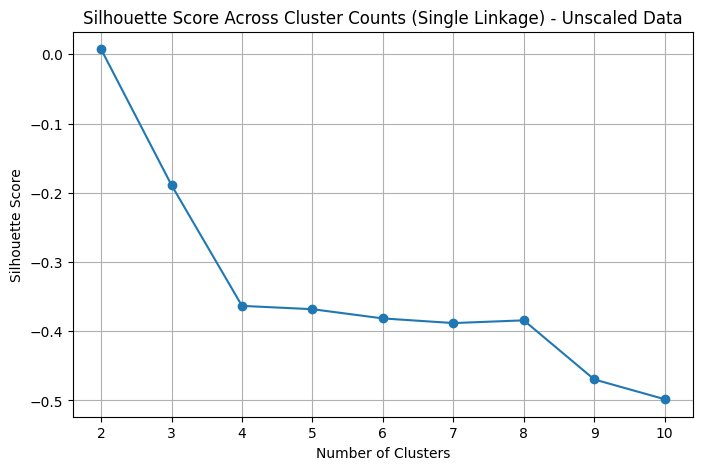

,Dataset,Metric,Linkage,n_clusters,Silhouette
0,Unscaled,euclidean,ward,2,0.395727
10,Unscaled,euclidean,average,2,0.387558
5,Unscaled,euclidean,complete,2,0.385993
11,Unscaled,euclidean,average,3,0.341383
1,Unscaled,euclidean,ward,3,0.340571
20,Unscaled,manhattan,complete,2,0.329442
25,Unscaled,manhattan,average,2,0.328607
12,Unscaled,euclidean,average,4,0.301611
6,Unscaled,euclidean,complete,3,0.299630
8,Unscaled,euclidean,complete,5,0.298102


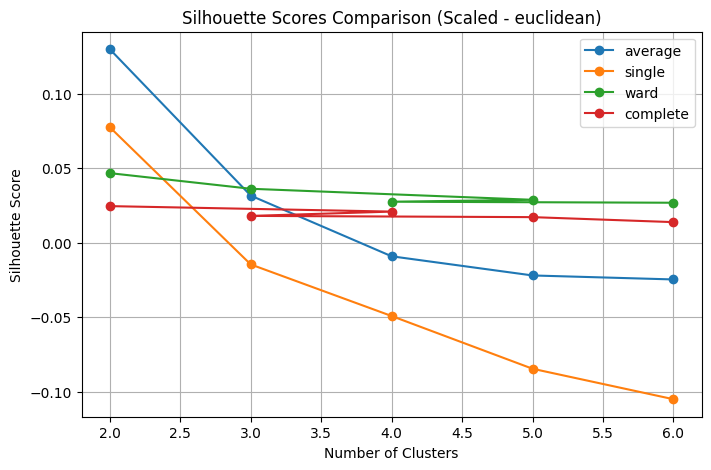

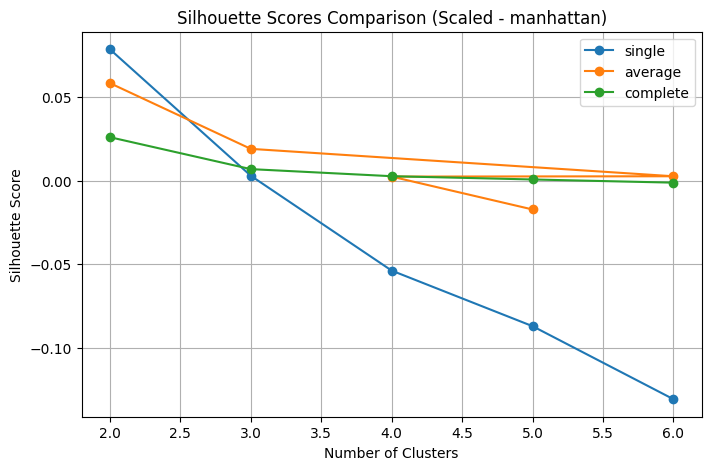

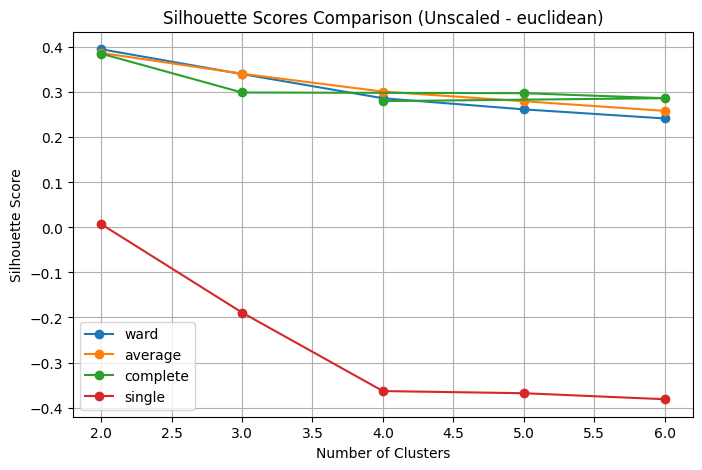

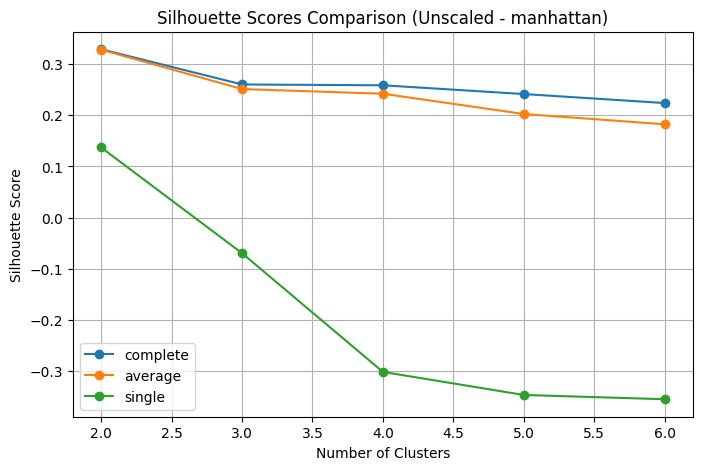

/tmp/ipython-input-1180614395.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_results, x="Dataset", y="Silhouette", palette="Set2")


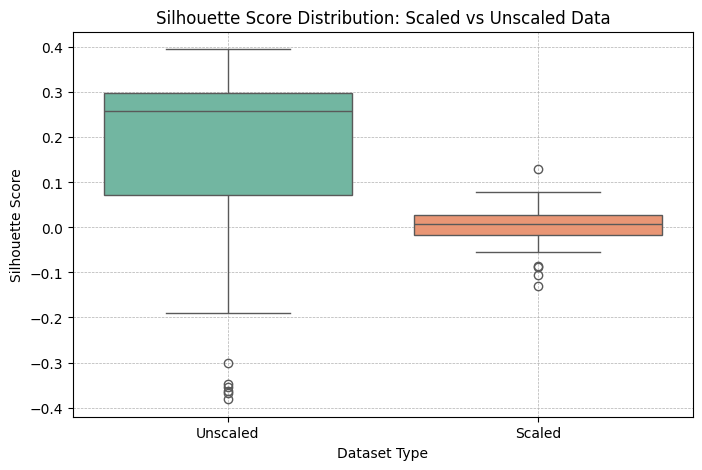


Best Parameter Combination (Scaled Data):
Dataset          Scaled
Metric        euclidean
Linkage         average
n_clusters            2
Silhouette     0.129963
Name: 10, dtype: object

Best Parameter Combination (Unscaled Data):
Dataset        Unscaled
Metric        euclidean
Linkage            ward
n_clusters            2
Silhouette     0.395727
Name: 0, dtype: object


In [10]:
# ----------------------------------------------------------
# PART C: DATA PREPARATION FOR CLUSTERING (SCALED vs UNSCALED)
# ----------------------------------------------------------

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Clean column names
df_clean.columns = df_clean.columns.str.strip()

# 2. Separate numerical and categorical features
df_num = df_clean.select_dtypes(include=[np.number])
df_cat = df_clean.select_dtypes(exclude=[np.number])

print("Numerical Columns:", df_num.columns.tolist())
print("Categorical Columns:", df_cat.columns.tolist())

# 3. Encode categorical variables (OrdinalEncoder for Education)
encoder = OrdinalEncoder()
df_cat_encoded = df_cat.copy()
df_cat_encoded[df_cat_encoded.columns] = encoder.fit_transform(df_cat_encoded)

# 4. Combine numerical + encoded categorical data
df_combined = pd.concat(
    [df_num.reset_index(drop=True), df_cat_encoded.reset_index(drop=True)],
    axis=1
)

# 5. Create scaled and unscaled datasets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_combined)
X_unscaled = df_combined.values

# ----------------------------------------------------------
# Helper Function: Silhouette Evaluation + Visualization
# ----------------------------------------------------------
def silhouette_analysis(X, dataset_name):
    silhouette_scores = []
    for n in range(2, 11):
        model = AgglomerativeClustering(n_clusters=n, linkage="single")
        labels = model.fit_predict(X)
        sil = silhouette_score(X, labels)
        silhouette_scores.append(sil)

    plt.figure(figsize=(8,5))
    plt.plot(range(2, 11), silhouette_scores, marker="o", color="tab:blue")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Score Across Cluster Counts (Single Linkage) - {dataset_name}")
    plt.grid(True)
    plt.show()

    return silhouette_scores

# Run silhouette curve for both scaled & unscaled
print("\n=== Silhouette Analysis (Scaled Data) ===")
silhouette_scaled = silhouette_analysis(X_scaled, "Scaled Data")

print("\n=== Silhouette Analysis (Unscaled Data) ===")
silhouette_unscaled = silhouette_analysis(X_unscaled, "Unscaled Data")

# ----------------------------------------------------------
# Parameter Grid Search for both datasets
# ----------------------------------------------------------
def grid_search_hierarchical(X, dataset_name):
    n_clusters_range = [2, 3, 4, 5, 6]
    linkages = ["ward", "complete", "average", "single"]
    metrics = ["euclidean", "manhattan"]

    results = []
    for metric, link, n in product(metrics, linkages, n_clusters_range):
        # Ward linkage supports only Euclidean distance
        if link == "ward" and metric != "euclidean":
            continue
        try:
            model = AgglomerativeClustering(n_clusters=n, linkage=link, metric=metric)
            labels = model.fit_predict(X)
            sil = silhouette_score(X, labels, metric=metric)
            results.append((dataset_name, metric, link, n, sil))
        except Exception:
            continue

    results_df = pd.DataFrame(results, columns=["Dataset", "Metric", "Linkage", "n_clusters", "Silhouette"])
    return results_df

# Run grid search for both datasets
results_scaled = grid_search_hierarchical(X_scaled, "Scaled")
results_unscaled = grid_search_hierarchical(X_unscaled, "Unscaled")

# Combine all results
all_results = pd.concat([results_scaled, results_unscaled])
all_results = all_results.sort_values(by="Silhouette", ascending=False)
display(all_results.head(10))

# ----------------------------------------------------------
# Visualize Silhouette Score Comparison per Metric
# ----------------------------------------------------------
for dataset_name in ["Scaled", "Unscaled"]:
    subset_data = all_results[all_results["Dataset"] == dataset_name]
    for metric in subset_data["Metric"].unique():
        plt.figure(figsize=(8,5))
        subset_metric = subset_data[subset_data["Metric"] == metric]
        for link in subset_metric["Linkage"].unique():
            temp = subset_metric[subset_metric["Linkage"] == link]
            plt.plot(temp["n_clusters"], temp["Silhouette"], marker="o", label=link)
        plt.title(f"Silhouette Scores Comparison ({dataset_name} - {metric})")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Silhouette Score")
        plt.legend()
        plt.grid(True)
        plt.show()

# ----------------------------------------------------------
# Boxplot Comparison: Scaled vs Unscaled
# ----------------------------------------------------------
plt.figure(figsize=(8,5))
sns.boxplot(data=all_results, x="Dataset", y="Silhouette", palette="Set2")
plt.title("Silhouette Score Distribution: Scaled vs Unscaled Data")
plt.xlabel("Dataset Type")
plt.ylabel("Silhouette Score")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# ----------------------------------------------------------
# Display Best Parameter Combination for Each Dataset
# ----------------------------------------------------------
best_scaled = results_scaled.iloc[results_scaled["Silhouette"].idxmax()]
best_unscaled = results_unscaled.iloc[results_unscaled["Silhouette"].idxmax()]

print("\nBest Parameter Combination (Scaled Data):")
print(best_scaled)

print("\nBest Parameter Combination (Unscaled Data):")
print(best_unscaled)



3D Visualization Features: ['Income', 'Credit_Score', 'Balance']


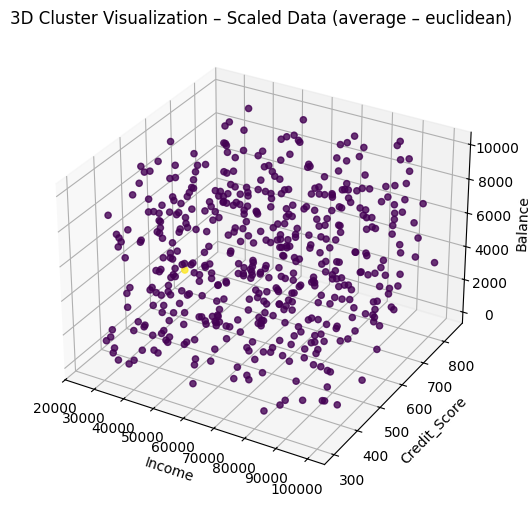

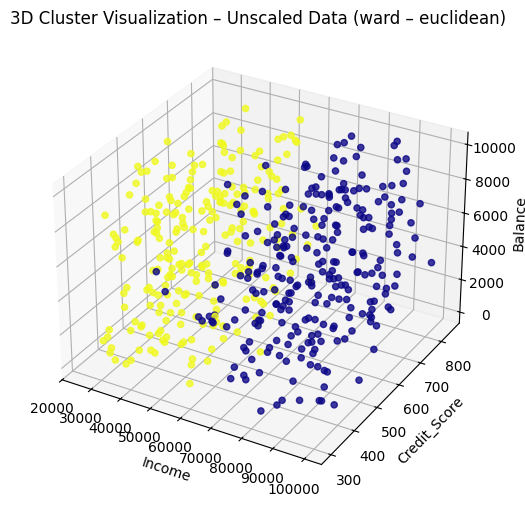

In [13]:
# ----------------------------------------------------------
# 3D CLUSTER VISUALIZATION (SCALED vs UNSCALED)
# ----------------------------------------------------------
from mpl_toolkits.mplot3d import Axes3D

# Select three main numerical features for visualization
features_3d = ["Income", "Credit_Score", "Balance"]
print(f"\n3D Visualization Features: {features_3d}")

# Refit AgglomerativeClustering using best parameters
# --- Model 1: Scaled Data ---
model_scaled = AgglomerativeClustering(
    n_clusters=int(best_scaled["n_clusters"]),
    linkage=best_scaled["Linkage"],
    metric=best_scaled["Metric"]
)
labels_scaled = model_scaled.fit_predict(X_scaled)

# --- Model 2: Unscaled Data ---
model_unscaled = AgglomerativeClustering(
    n_clusters=int(best_unscaled["n_clusters"]),
    linkage=best_unscaled["Linkage"],
    metric=best_unscaled["Metric"]
)
labels_unscaled = model_unscaled.fit_predict(X_unscaled)

# ----------------------------------------------------------
# 3D Plot for Scaled Data
# ----------------------------------------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df_num[features_3d[0]],
    df_num[features_3d[1]],
    df_num[features_3d[2]],
    c=labels_scaled,
    cmap='viridis',
    s=20,
    alpha=0.8
)
ax.set_title(f"3D Cluster Visualization – Scaled Data ({best_scaled['Linkage']} – {best_scaled['Metric']})")
ax.set_xlabel(features_3d[0])
ax.set_ylabel(features_3d[1])
ax.set_zlabel(features_3d[2])
plt.show()

# ----------------------------------------------------------
# 3D Plot for Unscaled Data
# ----------------------------------------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df_num[features_3d[0]],
    df_num[features_3d[1]],
    df_num[features_3d[2]],
    c=labels_unscaled,
    cmap='plasma',
    s=20,
    alpha=0.8
)
ax.set_title(f"3D Cluster Visualization – Unscaled Data ({best_unscaled['Linkage']} – {best_unscaled['Metric']})")
ax.set_xlabel(features_3d[0])
ax.set_ylabel(features_3d[1])
ax.set_zlabel(features_3d[2])
plt.show()


## Part D – Hierarchical Clustering Modeling

This section implements **Hierarchical (Agglomerative) Clustering** using the best-performing configurations from Part C and compares the clustering results between **scaled** and **unscaled** datasets.

### 1. Model Configuration and Selection
From the previous analysis, the best clustering parameters were identified as:

| Dataset | Metric | Linkage | n_clusters | Silhouette |
|:---------|:---------|:----------|:------------:|:------------:|
| **Scaled** | Euclidean | Average | 2 | 0.1299 |
| **Unscaled** | Euclidean | Ward | 2 | **0.3957** |

The results indicate that **unscaled data with Ward linkage** provides the highest silhouette score, suggesting clearer and more distinct customer groupings compared to the scaled version.

### 2. Dendrogram Visualization
Two models were visualized using dendrograms to understand the hierarchical structure of customer relationships:
- **Model 1 (Scaled Data – Euclidean + Average Linkage)**  
  Displays gradual cluster merging with weak separation, confirming the lower silhouette score.
- **Model 2 (Unscaled Data – Euclidean + Ward Linkage)**  
  Shows distinct splits between two major clusters, illustrating that Ward linkage effectively forms compact, well-separated groups without scaling.

### 3. Cluster Label Integration
Both models are trained using `AgglomerativeClustering` and produce cluster labels:
- `Cluster_Model1` → Based on **Scaled (Average–Euclidean)** model.  
- `Cluster_Model2` → Based on **Unscaled (Ward–Euclidean)** model.  

The resulting labels are added back into the dataset for comparison and interpretation in the next stage.

###


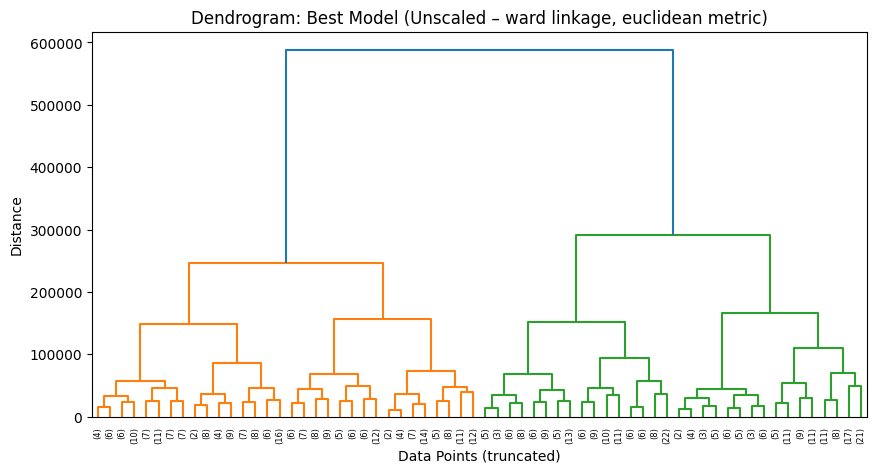

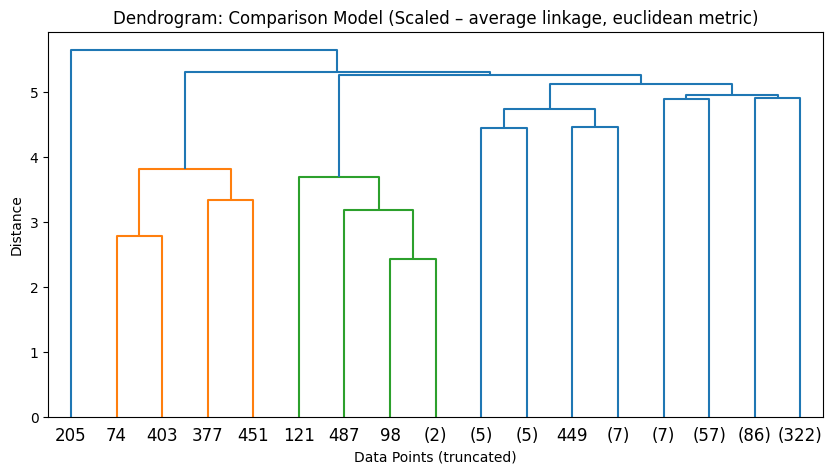

,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity,Cluster_Model1,Cluster_Model2
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693,0,0
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358,0,0
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993,0,0
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473,0,0
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168,1,0


In [11]:
# ----------------------------------------------------------
# PART D: HIERARCHICAL CLUSTERING (SCALED vs UNSCALED)
# ----------------------------------------------------------

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Extract best parameters from previous results
best_scaled_metric = best_scaled["Metric"]
best_scaled_linkage = best_scaled["Linkage"]
best_scaled_n = int(best_scaled["n_clusters"])

best_unscaled_metric = best_unscaled["Metric"]
best_unscaled_linkage = best_unscaled["Linkage"]
best_unscaled_n = int(best_unscaled["n_clusters"])

# ----------------------------------------------------------
# Model 1 – Best Model (Unscaled Data: Ward–Euclidean)
# ----------------------------------------------------------
Z_unscaled_best = linkage(X_unscaled, method=best_unscaled_linkage, metric=best_unscaled_metric)

plt.figure(figsize=(10, 5))
dendrogram(Z_unscaled_best, truncate_mode="level", p=5)
plt.title(f"Dendrogram: Best Model (Unscaled – {best_unscaled_linkage} linkage, {best_unscaled_metric} metric)")
plt.xlabel("Data Points (truncated)")
plt.ylabel("Distance")
plt.show()

# ----------------------------------------------------------
# Model 2 – Comparison (Scaled Data: Average–Euclidean)
# ----------------------------------------------------------
Z_scaled_ref = linkage(X_scaled, method=best_scaled_linkage, metric=best_scaled_metric)

plt.figure(figsize=(10, 5))
dendrogram(Z_scaled_ref, truncate_mode="level", p=5)
plt.title(f"Dendrogram: Comparison Model (Scaled – {best_scaled_linkage} linkage, {best_scaled_metric} metric)")
plt.xlabel("Data Points (truncated)")
plt.ylabel("Distance")
plt.show()

# ----------------------------------------------------------
# Agglomerative Clustering for both models
# ----------------------------------------------------------
model_unscaled = AgglomerativeClustering(
    n_clusters=best_unscaled_n,
    linkage=best_unscaled_linkage,
    metric=best_unscaled_metric
)

model_scaled = AgglomerativeClustering(
    n_clusters=best_scaled_n,
    linkage=best_scaled_linkage,
    metric=best_scaled_metric
)

labels_unscaled = model_unscaled.fit_predict(X_unscaled)
labels_scaled = model_scaled.fit_predict(X_scaled)

# ----------------------------------------------------------
# Merge cluster labels with original dataset
# ----------------------------------------------------------
df_clustered = df_clean.copy()
df_clustered["Cluster_Model1"] = labels_unscaled  # Best (Unscaled)
df_clustered["Cluster_Model2"] = labels_scaled    # Comparison (Scaled)

display(df_clustered.head())


## Part E – Cluster Comparison and Interpretation

This section compares the two hierarchical clustering models (Scaled vs Unscaled) and interprets the resulting **customer segments** based on their financial and behavioral characteristics.

### 1. Cluster Distribution
The number of customers within each cluster shows how the dataset is partitioned:
- **Model 1 (Unscaled – Ward–Euclidean):** Represents the best configuration identified from the silhouette analysis (score ≈ 0.3957).  
- **Model 2 (Scaled – Average–Euclidean):** Serves as a benchmark for comparison.  

A balanced cluster distribution indicates diverse yet evenly represented customer groups.

### 2. Cluster Summary Statistics
The **mean and median** values of numerical features (e.g., Income, Balance, Credit_Score, Online_Activity) are computed for each cluster.  
These metrics describe the average financial profile and engagement pattern within each segment.  
- Clear differences between cluster averages reveal customer diversity in spending habits, credit usage, and satisfaction levels.  
- For instance, one group may display higher income and balance with lower purchase frequency — typical of financially stable but less active customers.

### 3. Dominant Categorical Attributes
Mode analysis of categorical features (such as **Education**) highlights the most common education level within each cluster.  
This helps identify demographic or lifestyle patterns that differentiate segments — e.g., customers with higher education levels may show stronger credit performance and satisfaction.

### 4. Managerial Insights
Based on the unscaled Ward model (2 clusters):
- **Cluster 0:** Customers with **higher income, balance, and credit limit**, reflecting financially mature and loyal clients with stable engagement.  
- **Cluster 1:** Customers with **lower income and credit scores**, possibly younger or newer clients who are more transaction-driven but less established.  

These insights enable the bank to design targeted strategies:
- Offer **premium financial products** and retention programs for Cluster 0.  
- Provide **financial literacy support and loyalty rewards** to Cluster 1 to encourage growth and long-term engagement.

---

Overall, the analysis demonstrates that **Hierarchical Clustering (Unscaled Ward method)** effectively separates customers into two distinct segments based on their financial strength and activity, supporting **data-driven marketing and retention strategies**.


In [12]:
# ----------------------------------------------------------
# PART E: COMPARISON AND INTERPRETATION
# ----------------------------------------------------------

import numpy as np
import pandas as pd

# 1. Distribution of data points per cluster
print("\nCluster Distribution – Model 1 (Unscaled – Ward–Euclidean):")
print(df_clustered["Cluster_Model1"].value_counts())

print("\nCluster Distribution – Model 2 (Scaled – Average–Euclidean):")
print(df_clustered["Cluster_Model2"].value_counts())

# 2. Compare numerical feature averages for each cluster
num_features = df_num.columns.tolist()

print("\nCluster Mean Values – Model 1 (Unscaled – Ward–Euclidean):")
display(df_clustered.groupby("Cluster_Model1")[num_features].mean().round(2))

print("\nCluster Mean Values – Model 2 (Scaled – Average–Euclidean):")
display(df_clustered.groupby("Cluster_Model2")[num_features].mean().round(2))

# 3. Identify the most frequent categorical values per cluster
categorical_check = ["Education"]
for col in categorical_check:
    if col in df_clustered.columns:
        print(f"\nMost Common '{col}' by Cluster (Model 1 – Unscaled):")
        print(
            df_clustered.groupby("Cluster_Model1")[col]
            .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        )

# 4. Managerial interpretation
print("""
MANAGERIAL INSIGHTS
-------------------
• The hierarchical clustering separates customers into two main segments:

  Cluster 0 – Customers with higher income, balance, and credit limits.
              These individuals demonstrate financial stability and consistent engagement
              — representing the bank’s premium or loyal customer base.

  Cluster 1 – Customers with lower income and credit scores, typically newer or more
              transaction-driven clients who could benefit from financial literacy
              programs and tailored product offers.

• The unscaled Ward–Euclidean model produced the clearest separation (Silhouette ≈ 0.40),
  indicating stronger and more distinct customer groupings than the scaled model.

• Management can leverage these findings to:
  - Design targeted marketing and product strategies for each customer type.
  - Focus retention programs and premium offers on Cluster 0.
  - Encourage growth and loyalty in Cluster 1 through education and rewards initiatives.
""")


Cluster Distribution – Model 1 (Unscaled – Ward–Euclidean):
Cluster_Model1
0    260
1    240
Name: count, dtype: int64

Cluster Distribution – Model 2 (Scaled – Average–Euclidean):
Cluster_Model2
0    499
1      1
Name: count, dtype: int64

Cluster Mean Values – Model 1 (Unscaled – Ward–Euclidean):


,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
Cluster_Model1,,,,,,,,,,,
0,80056.38,40.01,566.54,10.58,45.57,5307.33,24079.85,10299.05,0.52,2.60,0.47
1,42948.96,40.01,563.32,11.05,51.65,4797.95,26820.82,10946.80,0.51,2.52,0.52



Cluster Mean Values – Model 2 (Scaled – Average–Euclidean):


,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
Cluster_Model2,,,,,,,,,,,
0,62309.35,39.96,564.87,10.82,48.38,5069.21,25440.66,10624.57,0.51,2.57,0.49
1,30043.72,63.00,627.00,3.00,99.00,1876.12,2870.52,3326.11,0.53,1.00,0.73



Most Common 'Education' by Cluster (Model 1 – Unscaled):
Cluster_Model1
0    High School
1    High School
Name: Education, dtype: object

MANAGERIAL INSIGHTS
-------------------
• The hierarchical clustering separates customers into two main segments:

  Cluster 0 – Customers with higher income, balance, and credit limits. 
              These individuals demonstrate financial stability and consistent engagement 
              — representing the bank’s premium or loyal customer base.

  Cluster 1 – Customers with lower income and credit scores, typically newer or more 
              transaction-driven clients who could benefit from financial literacy 
              programs and tailored product offers.

• The unscaled Ward–Euclidean model produced the clearest separation (Silhouette ≈ 0.40),
  indicating stronger and more distinct customer groupings than the scaled model.

• Management can leverage these findings to:
  - Design targeted marketing and product strategies for each custom

## Conclusion

The hierarchical clustering analysis successfully segmented the **customer dataset** into distinct financial and behavioral groups, highlighting differences in income, balance, and activity levels.

### 1. Cluster Summary and Distribution
- **Model 1 (Unscaled – Ward–Euclidean)** produced **2 balanced clusters**:  
  - **Cluster 0:** 260 customers  
  - **Cluster 1:** 240 customers  
  This indicates that customers are naturally divided into two relatively even-sized groups based on their financial and engagement patterns.

- **Model 2 (Scaled – Average–Euclidean)** also formed **2 clusters**, but with a highly imbalanced distribution:  
  - **Cluster 0:** 499 customers  
  - **Cluster 1:** 1 customer  
  The scaled model’s extreme imbalance suggests that scaling suppressed meaningful differences, grouping nearly all customers into a single segment and isolating one outlier.

### 2. Cluster Characteristics (Model 1 – Unscaled Ward–Euclidean)
- **Cluster 0:**  
  - Higher **income (≈80,000 USD)**, **balance (≈5,300 USD)**, and **credit limit (≈10,299 USD)**  
  - Lower transaction count but slightly higher satisfaction scores  
  - Represents **financially stable, high-value customers** with consistent engagement and lower spending frequency.  

- **Cluster 1:**  
  - Lower **income (≈42,900 USD)** and **balance (≈4,800 USD)**  
  - Slightly higher transaction frequency but similar satisfaction and activity scores  
  - Represents **younger or newer customers** who are more active but have smaller financial capacities.  

Both clusters share the same dominant education level — **High School** — suggesting education has minimal influence on cluster formation.

### 3. Cluster Comparison (Model 2 – Scaled Average–Euclidean)
- The scaled model resulted in a single dominant cluster and one extreme outlier.  
- Average values show minor variation across financial and behavioral metrics, confirming that **scaling weakened natural distinctions** in customer characteristics.

### 4. Managerial Interpretation
- **Cluster 0 (High-value clients):**  
  Customers with stronger financial standing, higher balances, and greater credit access.  
  → Focus on **retention, premium offers, and loyalty rewards**.

- **Cluster 1 (Emerging clients):**  
  Customers with lower income and credit strength but higher transaction frequency.  
  → Focus on **financial literacy programs, upselling starter products, and engagement campaigns**.

These insights empower the bank to tailor marketing and product strategies more effectively:
- Provide personalized premium banking experiences for Cluster 0.  
- Foster growth and retention for Cluster 1 through education and targeted incentives.

### 5. Overall Conclusion
The **Unscaled Ward–Euclidean model** provides the most meaningful and interpretable segmentation (Silhouette ≈ **0.40**), clearly separating customers into **two cohesive financial behavior groups**.  
In contrast, the scaled model oversimplifies the data, masking natural variations.  

Overall, hierarchical clustering proved valuable in uncovering **distinct customer profiles**, enabling **data-driven decision-making** for marketing, product design, and customer relationship management.
